In [253]:
import scipy.io
import pynapple as nap
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from assembly  import runSignificance,extractPatterns,runPatterns, computeAssemblyActivity
from assembly_plot import plot_assembly_activity, plot_assembly_patterns, plot_assembly_counts, plot_assembly_activity_overtime, normalize_patterns
from Process import process_epochs_and_neurons
from scipy import stats
from scipy.stats import shapiro, ttest_rel, wilcoxon
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib import gridspec, rcParams
from matplotlib.colors import Normalize
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM

## Importing Data

In [4]:
warnings.filterwarnings('ignore')
p_path = "D:/Research Topic/tristan/step10_olivadata"
A013_day7_bins  , A013_day7_bins_p, A013_day7_total , A013_day7_ca2_p,  A013_day7_ca3_p,  A013_day7_ca1_p,  A013_day7_ca2_inter,  A013_day7_ca3_inter,  A013_day7_ca1_inter,  A013_day7_ca2_p_id,  A013_day7_ca3_p_id,  A013_day7_ca1_p_id,  A013_day7_ca2_inter_id,  A013_day7_ca3_inter_id,  A013_day7_ca1_inter_id  = process_epochs_and_neurons(p_path,'A013_day7')

include_epoch = {'A013_day7_rest_hab_pre', 'A013_day7_habituation_arena', 'A013_day7_rest_hab_post',
                 'A013_day7_habituation_cage', 'A013_day7_rest_pre', 'A013_day7_2novel_exposure',
                 'A013_day7_exposure_reversed', 'A013_day7_rest_post2', 'A013_day7_1novel_exposure', 'A013_day7_rest_post1'}
A013_day7_all = dict(filter(lambda item: item[0] in include_epoch, A013_day7_bins_p.items()))
A013_day7 = {}
A013_day7['A013_day7_rest_hab_pre'] = A013_day7_all['A013_day7_rest_hab_pre']
A013_day7['A013_day7_habituation_arena'] = A013_day7_all['A013_day7_habituation_arena']
A013_day7['A013_day7_rest_hab_post'] = A013_day7_all['A013_day7_rest_hab_post']
A013_day7['A013_day7_habituation_cage'] = A013_day7_all['A013_day7_habituation_cage']
A013_day7['A013_day7_rest_pre'] = A013_day7_all['A013_day7_rest_pre']
A013_day7['A013_day7_2novel_exposure'] = A013_day7_all['A013_day7_2novel_exposure']
A013_day7['A013_day7_exposure_reversed'] = A013_day7_all['A013_day7_exposure_reversed']
#A013_day7['A013_day7_Task'] = pd.concat([A013_day7_all['A013_day7_2novel_exposure'], A013_day7_all['A013_day7_exposure_reversed']])
A013_day7['A013_day7_rest_post2'] = A013_day7_all['A013_day7_rest_post2']
A013_day7['A013_day7_1novel_exposure'] = A013_day7_all['A013_day7_1novel_exposure']
A013_day7['A013_day7_rest_post1'] = A013_day7_all['A013_day7_rest_post1']

## Assembly Operation

Epoch: A013_day7_rest_hab_pre, Assembly 1 - Neurons above threshold: [1, 4, 6, 17, 18, 19, 2, 14, 15]
Epoch: A013_day7_rest_hab_pre, Assembly 2 - Neurons above threshold: [3, 25, 2, 5, 12, 14, 16, 28]
Epoch: A013_day7_rest_hab_pre, Assembly 3 - Neurons above threshold: [8, 9, 18, 19, 22, 25, 2, 11, 14, 27, 28]
Epoch: A013_day7_rest_hab_pre, Assembly 4 - Neurons above threshold: [3, 4, 6, 18, 19, 20, 21, 23, 29, 15]
Epoch: A013_day7_rest_hab_pre, Assembly 5 - Neurons above threshold: [6, 8, 19, 10, 12, 13, 14, 27, 28]
Epoch: A013_day7_rest_hab_pre, Assembly 6 - Neurons above threshold: [4, 6, 18, 24, 25, 26]
Epoch: A013_day7_rest_hab_pre, Assembly 7 - Neurons above threshold: [20, 29, 30, 31]
Epoch: A013_day7_habituation_arena, Assembly 1 - Neurons above threshold: [1, 3, 18, 21, 22, 23, 29, 10, 11, 13, 14, 15, 27, 28]
Epoch: A013_day7_habituation_arena, Assembly 2 - Neurons above threshold: [1, 4, 8, 9, 18, 20, 22, 24, 25, 26, 12, 13]
Epoch: A013_day7_habituation_arena, Assembly 3 - Ne

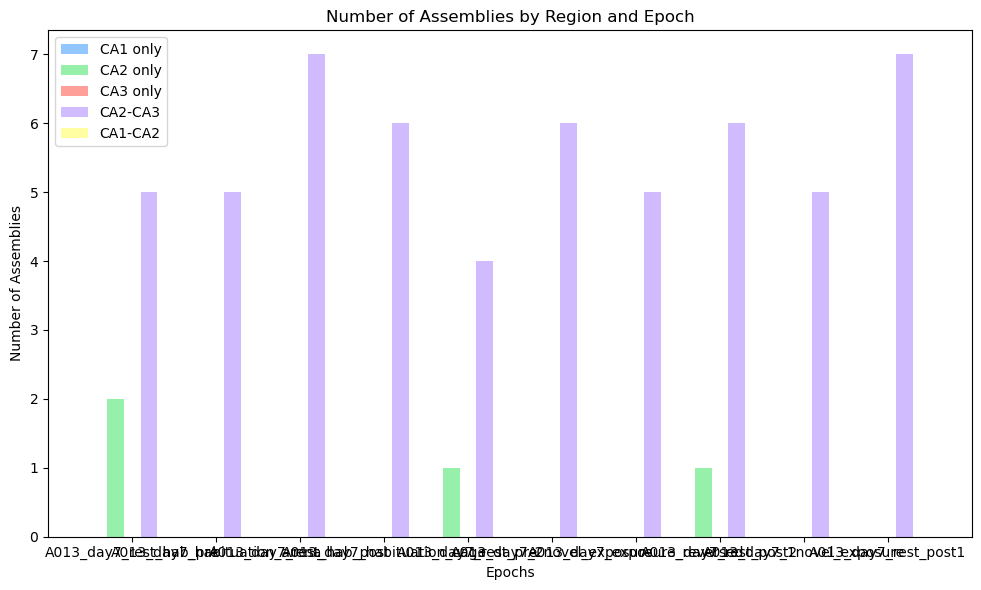

In [5]:
assembly_activities = {}
trace=  {}
patterns = {}
zactmats = {}
pjs= {}
for epoch_name, epoch_data in A013_day7.items():
    # Run the function for cell assemblies (replace with actual function call and parameters)
    patterns_epoch, significance, zactmat = runPatterns(epoch_data.values.T, method='ica', nullhyp='mp')
    assembly_activity, pj = computeAssemblyActivity(patterns_epoch, zactmat)
    patterns_epoch = normalize_patterns(patterns_epoch)
    
    # Store results
    assembly_activities[epoch_name] = assembly_activity
    patterns[epoch_name] = patterns_epoch
    zactmats[epoch_name] = zactmat
    pjs[epoch_name] = pj
    
    
assembly_counts,pattern_type= plot_assembly_patterns(patterns, list(A013_day7.keys()), A013_day7_ca2_p_id, A013_day7_ca3_p_id, A013_day7_ca1_p_id)
plot_assembly_counts(assembly_counts, list(A013_day7.keys()))


#total_zacmat = stats.zscore(A013_day7_total.values.T)
#total_zacmat[np.isnan(total_zacmat)] = 0
#assembly_activity, pj = computeAssemblyActivity(patterns['A013_day7_Task'], total_zacmat)

## Significant Assemblies

In [10]:
# Function to find significant assemblies in CA2 and CA3
def find_significant_assemblies(patterns_epoch, ca2_indices, ca3_indices, threshold):
    significant_assemblies = []
    for i, pattern in enumerate(patterns_epoch):
        above_threshold = np.where(pattern > threshold)[0]
        #Specify Joint Assemblies Between CA2-CA3
        if any(neuron in ca2_indices for neuron in above_threshold) and any(neuron in ca3_indices for neuron in above_threshold):
            significant_assemblies.append(i)
    return significant_assemblies

# Identify significant assemblies in 'A013_day7_2novel_exposure'
epoch_name_Task = 'A013_day7_2novel_exposure'
threshold_Task = abs(1/np.sqrt(len(patterns[epoch_name_Task][0])))
significant_assemblies_Task = find_significant_assemblies(patterns[epoch_name_Task], A013_day7_ca2_p_id, A013_day7_ca3_p_id, threshold_Task)
print(f"Significant Joint CA2-CA3 assemblies in {epoch_name_Task}: {significant_assemblies_Task}")

epoch_name_hab_cage = 'A013_day7_habituation_cage'
threshold_hab_cage = abs(1/np.sqrt(len(patterns[epoch_name_hab_cage][0])))
significant_assemblies_hab_cage = find_significant_assemblies(patterns[epoch_name_hab_cage], A013_day7_ca2_p_id, A013_day7_ca3_p_id, threshold_hab_cage)
print(f"Significant Joint CA2-CA3 assemblies in {epoch_name_hab_cage}: {significant_assemblies_hab_cage}")


epoch_name_hab_arena = 'A013_day7_habituation_arena'
threshold_hab_arena = abs(1/np.sqrt(len(patterns[epoch_name_hab_arena][0])))
significant_assemblies_hab_arena = find_significant_assemblies(patterns[epoch_name_hab_arena], A013_day7_ca2_p_id, A013_day7_ca3_p_id, threshold_hab_arena)
print(f"Significant Joint CA2-CA3 assemblies in {epoch_name_hab_arena}: {significant_assemblies_hab_arena}")

Significant Joint CA2-CA3 assemblies in A013_day7_2novel_exposure: [0, 1, 2, 3, 4, 5]
Significant Joint CA2-CA3 assemblies in A013_day7_habituation_cage: [0, 1, 2, 3, 4, 5]
Significant Joint CA2-CA3 assemblies in A013_day7_habituation_arena: [0, 1, 2, 3, 4]


## Trace Joint CA2-CA3 Social Cell Assemblies over Time

In [12]:
# Compute the activity of significant joint ca2-ca3 cell assemblies in the 'A013_day7_2novel_exposure' epoch
significant_patterns_social = [patterns[epoch_name_Task][i] for i in significant_assemblies_Task]
#assembly_activity_exposure  , project_mat = computeAssemblyActivity(significant_patterns, zactmats[epoch_name_Task])

In [14]:
Social_joint_CA2_CA3_assembly_activities_over_time = {}

for epoch_name, zactmat in zactmats.items():
    #if epoch_name != 'A013_day7_2novel_exposure':  # Skip the original epoch
    projected_activity,pj_combined = computeAssemblyActivity(significant_patterns_social, zactmat)
    Social_joint_CA2_CA3_assembly_activities_over_time[epoch_name] = projected_activity



threshold = abs(1/np.sqrt(len(patterns[epoch_name_Task][0])))  
# Iterate through each pattern and set non-member weights to zero
for i, pattern in enumerate(significant_patterns_social):
    abs_pattern = np.abs(pattern)
    pattern[abs_pattern < threshold] = 0

#significant_patterns_social

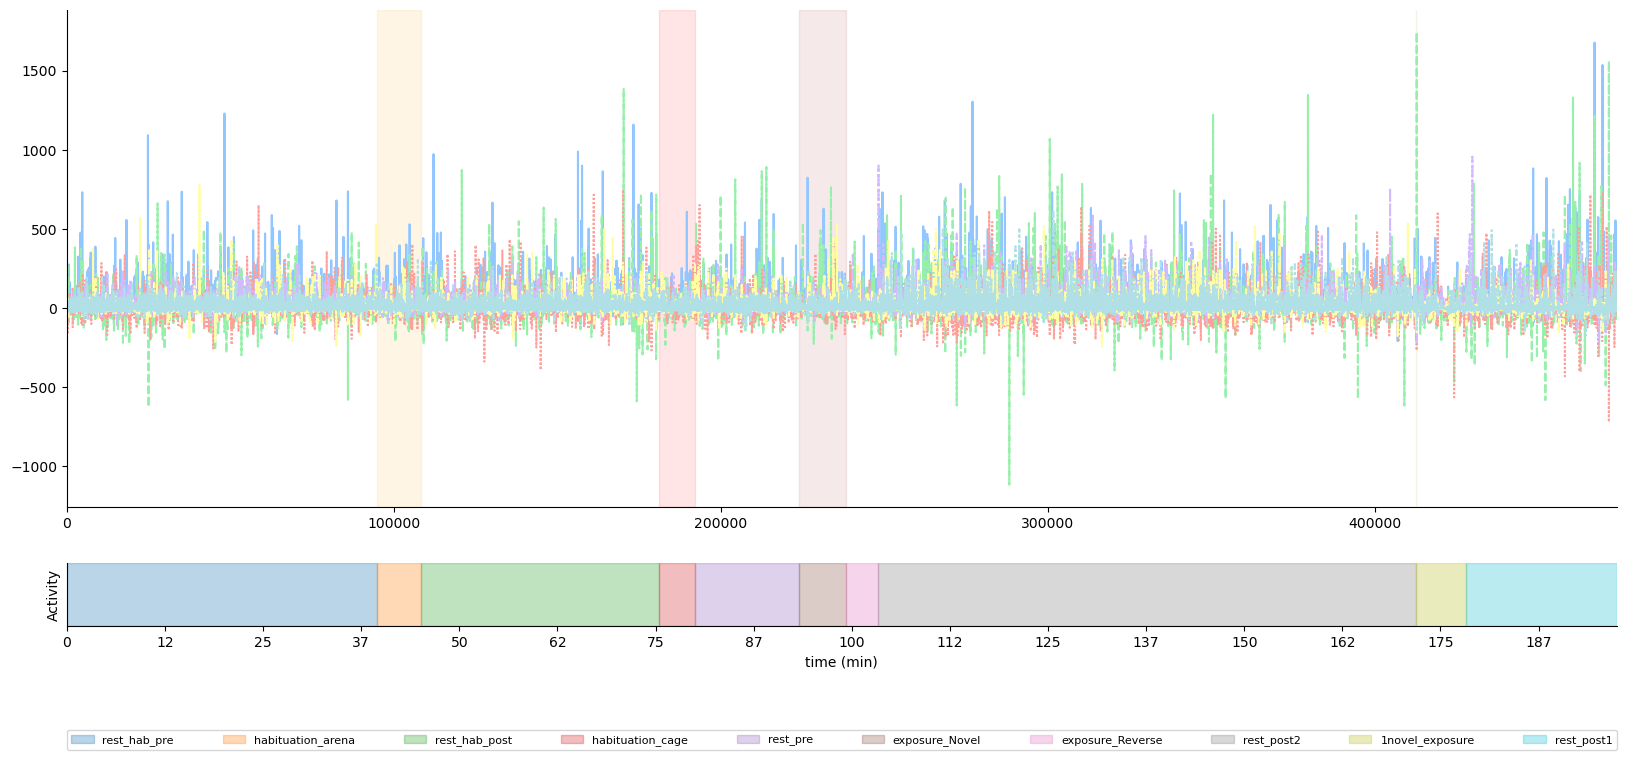

In [15]:
epoch_lengths = [
    len(A013_day7_bins_p['A013_day7_rest_hab_pre'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_habituation_arena'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_hab_post'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_habituation_cage'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_pre'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_2novel_exposure'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_exposure_reversed'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_post2'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_1novel_exposure'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_post1'].to_numpy())
]

epoch_lengths

plot_assembly_activity_overtime(Social_joint_CA2_CA3_assembly_activities_over_time, epoch_lengths)

## Tracing Joint CA2-CA3 non-Social Cell Assemblies over Time

In [18]:
significant_patterns_non_social = [patterns[epoch_name_hab_arena][i] for i in significant_assemblies_hab_arena]

for i, pattern in enumerate(significant_patterns_non_social):
    abs_pattern = np.abs(pattern)
    pattern[abs_pattern < threshold_hab_arena] = 0

In [19]:
Non_Social_joint_CA2_CA3_assembly_activities_over_time = {}

for epoch_name, zactmat in zactmats.items():
    #if epoch_name != 'A013_day7_2novel_exposure':  # Skip the original epoch
    projected_activity,pj_combined = computeAssemblyActivity(significant_patterns_non_social, zactmat)
    Non_Social_joint_CA2_CA3_assembly_activities_over_time[epoch_name] = projected_activity

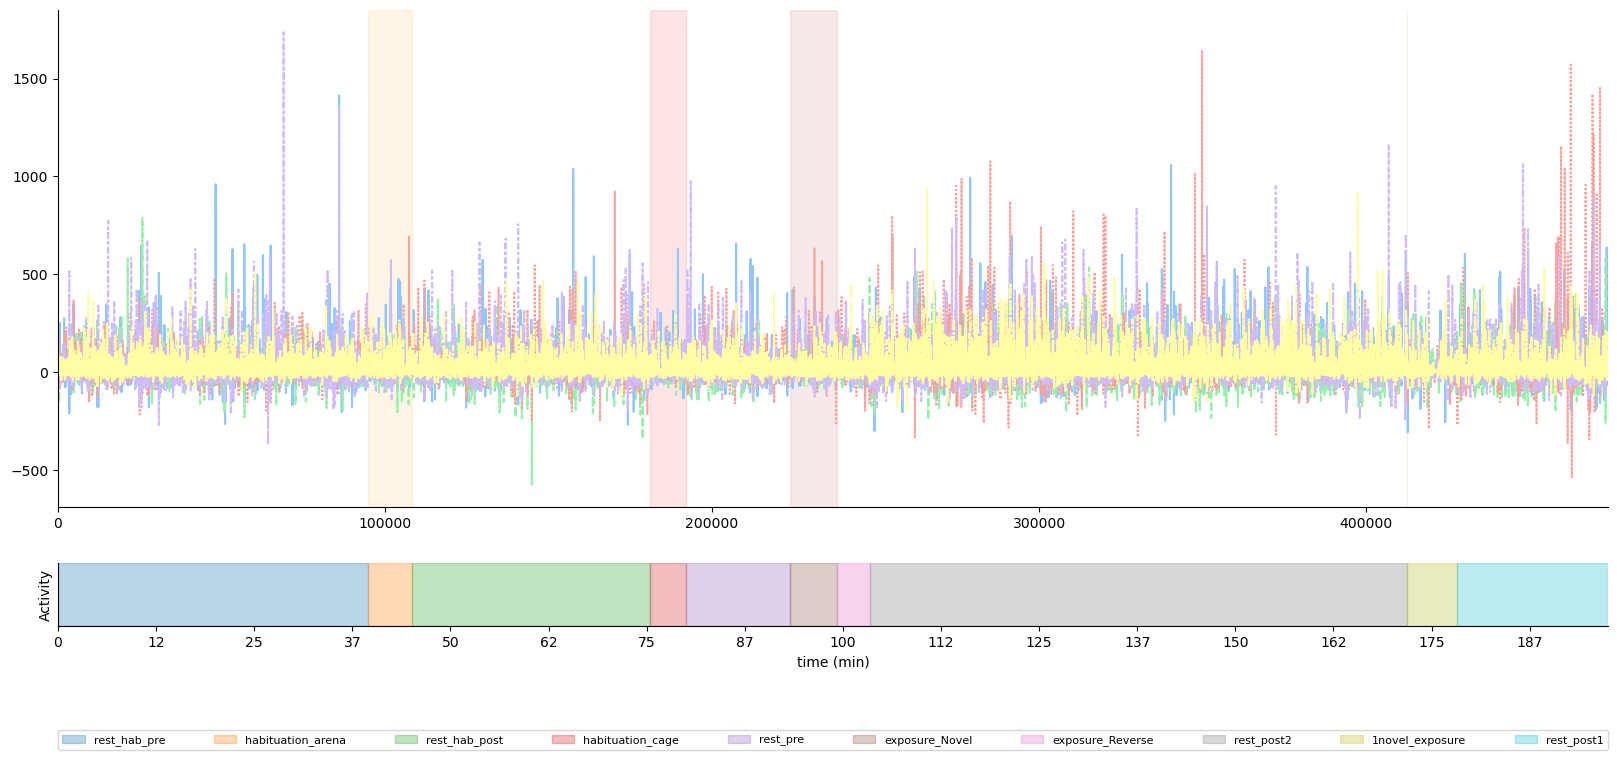

In [20]:
epoch_lengths = [
    len(A013_day7_bins_p['A013_day7_rest_hab_pre'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_habituation_arena'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_hab_post'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_habituation_cage'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_pre'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_2novel_exposure'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_exposure_reversed'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_post2'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_1novel_exposure'].to_numpy()),
    len(A013_day7_bins_p['A013_day7_rest_post1'].to_numpy())
]

epoch_lengths
plot_assembly_activity_overtime(Non_Social_joint_CA2_CA3_assembly_activities_over_time, epoch_lengths)

## Statistical Analysis Part 1: 

<b> Social Joint Assembley have higher Activation rate in post sleep vs pre sleep and the difference decline over time <b>

In [49]:
activitiy_aboveTresh_social = {}
for epoch, activity in Social_joint_CA2_CA3_assembly_activities_over_time.items():
    threshold_activity = 5
    activity_above = activity[activity > threshold_activity]
    activitiy_aboveTresh_social[epoch] = activity_above

In [51]:
rest_pre = activitiy_aboveTresh_social['A013_day7_rest_pre']
rest_post2 = activitiy_aboveTresh_social['A013_day7_rest_post2']
x = [len(rest_pre), len(rest_post2)]
x

[7089, 29536]

In [53]:
stat_pre, p_pre = shapiro(rest_pre)
stat_post2, p_post2 = shapiro(rest_post2)
print(f"Shapiro-Wilk Test for 'A013_day7_rest_pre': Statistics={p_pre}, p-value={stat_pre}")
print(f"Shapiro-Wilk Test for 'A013_day7_rest_post2': Statistics={p_post2}, p-value={stat_post2}")

Shapiro-Wilk Test for 'A013_day7_rest_pre': Statistics=3.5320500046477025e-91, p-value=0.4450771077553122
Shapiro-Wilk Test for 'A013_day7_rest_post2': Statistics=6.395696145631343e-125, p-value=0.5366977113838951


In [55]:
min_length = min(len(rest_pre), len(rest_post2))
rest_pre = rest_pre[:min_length]
rest_post2 = rest_post2[:min_length]

In [57]:
stat, p_value = ttest_rel(rest_pre, rest_post2)

print(f"Paired t-test: t-statistic = {stat}, p-value = {p_value}")

Paired t-test: t-statistic = -18.886404384730604, p-value = 1.162896471378479e-77


In [59]:
rest_pre = activitiy_aboveTresh_social['A013_day7_rest_pre'][:min_length]
rest_post2 = activitiy_aboveTresh_social['A013_day7_rest_post2'][min_length:min_length*2]

In [61]:
stat, p_value = ttest_rel(rest_pre, rest_post2)

print(f"Paired t-test: t-statistic = {stat}, p-value = {p_value}")

Paired t-test: t-statistic = -9.939217925102366, p-value = 3.979700531935872e-23


In [63]:
rest_pre = activitiy_aboveTresh_social['A013_day7_rest_pre'][:min_length]
rest_post2 = activitiy_aboveTresh_social['A013_day7_rest_post2'][min_length*2:min_length*3]

In [65]:
stat, p_value = ttest_rel(rest_pre, rest_post2)

print(f"Paired t-test: t-statistic = {stat}, p-value = {p_value}")

Paired t-test: t-statistic = -5.000200501065761, p-value = 5.864601961021557e-07


Social joint assemblies exhibited higher activation rates during post-sleep compared to pre-sleep periods. This difference diminishes over the course of the sleep session, consistent with previous observations that reactivations rapidly decline over the 
first hour of NREM sleep (G. Girardeau, Inema, and Buzsáki 2017; Miyawaki and Mizuseki 2022).

## Statistical Analysis Part 2: 

<b> Non Social Joint assemblies also have higher activation in post sleep <b>

In [67]:
activitiy_aboveTresh_nonSocial = {}
for epoch, activity in Non_Social_joint_CA2_CA3_assembly_activities_over_time.items():
    threshold_activity = 5
    activity_above = activity[activity > threshold_activity]
    activitiy_aboveTresh_nonSocial[epoch] = activity_above

In [71]:
rest_pre = activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_pre']
rest_post2 = activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_post']
x = [len(rest_pre), len(rest_post2)]
x

[19123, 14994]

In [73]:
stat_pre, p_pre = shapiro(rest_pre)
stat_post2, p_post2 = shapiro(rest_post2)
print(f"Shapiro-Wilk Test for 'A013_day7_rest_pre': Statistics={p_pre}, p-value={stat_pre}")
print(f"Shapiro-Wilk Test for 'A013_day7_rest_post2': Statistics={p_post2}, p-value={stat_post2}")

Shapiro-Wilk Test for 'A013_day7_rest_pre': Statistics=2.876569882154698e-117, p-value=0.457175845632233
Shapiro-Wilk Test for 'A013_day7_rest_post2': Statistics=2.4731718358918517e-108, p-value=0.5013876533157


In [79]:
min_length = min(len(activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_pre']), len(activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_post']))
rest_pre = activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_pre'][:min_length]
rest_post2 = activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_post'][:min_length]

In [81]:
stat, p_value = ttest_rel(rest_pre, rest_post2)

print(f"Paired t-test: t-statistic = {stat}, p-value = {p_value}")

Paired t-test: t-statistic = -2.6969425029165897, p-value = 0.007005755829003007


<b> Non social joint cell assemblies in pre sleep also has greater activation, but not as much as social stimulus <b>

## Statistical Analysis Part 3:

<b> Activation rates of both social and non-social joint assemblies during sleep following social stimulus were signficantly higher than following non-social experience <b>

In [103]:
#Social stimulus

rest_after_nonSocial = activitiy_aboveTresh_social['A013_day7_rest_hab_post']
rest_after_Social = activitiy_aboveTresh_social['A013_day7_rest_post2']
x = [len(rest_after_nonSocial), len(rest_after_Social)]
min_length = min(len(rest_after_nonSocial), len(rest_after_Social))
rest_after_nonSocial = rest_after_nonSocial[:min_length]
rest_after_Social = rest_after_Social[:min_length]
stat, p_value = ttest_rel(rest_after_nonSocial, rest_after_Social)

print(f"Paired t-test: t-statistic = {stat}, p-value = {p_value}")

Paired t-test: t-statistic = -17.18119450170771, p-value = 1.568795351988941e-65


In [101]:
#Non social stimulus

rest_after_nonSocial = activitiy_aboveTresh_nonSocial['A013_day7_rest_hab_post']
rest_after_Social = activitiy_aboveTresh_nonSocial['A013_day7_rest_post2']

min_length = min(len(rest_after_nonSocial), len(rest_after_Social))
rest_after_nonSocial = rest_after_nonSocial[:min_length]
rest_after_Social = rest_after_Social[:min_length]
stat, p_value = ttest_rel(rest_after_nonSocial, rest_after_Social)

print(f"Paired t-test: t-statistic = {stat}, p-value = {p_value}")

Paired t-test: t-statistic = -15.124718125926593, p-value = 2.659650478024175e-51


## Activity of Social and Non-Social Joint Assemblies

In [216]:
activitiy_aboveTresh_social = {}
for epoch, activity in Social_joint_CA2_CA3_assembly_activities_over_time.items():
    threshold_activity = 5
    activity_above = activity[activity > threshold_activity]
    activitiy_aboveTresh_social[epoch] = activity_above

In [218]:
def bin_data(data, num_bins):
    bin_edges = np.linspace(0, len(data), num_bins + 1, endpoint=True, dtype=int)
    binned_means = np.array([data[bin_edges[i]:bin_edges[i + 1]].mean() for i in range(num_bins)])
    binned_stds = np.array([data[bin_edges[i]:bin_edges[i + 1]].std()/np.sqrt(10) for i in range(num_bins)])
    return binned_means, binned_stds

# Define number of bins
num_bins = 10
binned_means_Social = {}
binned_stds_Social = {}

for condition, activity in activitiy_aboveTresh_social.items():
    binned_means_Social[condition], binned_stds_Social[condition] = bin_data(activity, num_bins)

# Concatenate data for sequential plotting
all_means_Social = np.concatenate([binned_means_Social[condition] for condition in binned_means_Social.keys()])
all_stds_Social = np.concatenate([binned_stds_Social[condition] for condition in binned_stds_Social.keys()])

condition_labels = []
for condition in binned_means_Social.keys():
    condition_labels += [condition] * num_bins

# Create a range for x-axis
x_range = range(len(all_means))

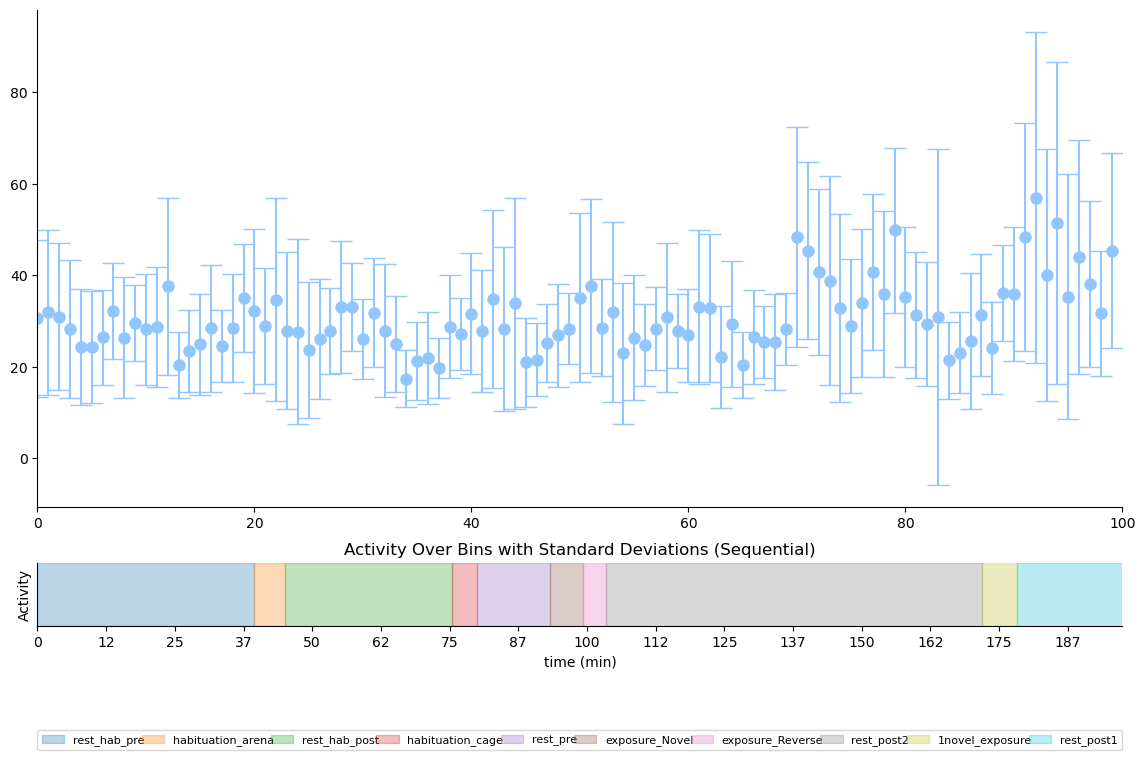

In [236]:
# Plotting
fig = plt.figure(figsize=(14, 8))
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
axs = []
intervals = []
start = 0
for length in epoch_lengths:
    end = start + length
    intervals.append((start, end))
    start = end
gs = gridspec.GridSpec(2, 1, height_ratios=[8, 1])
axs.append(fig.add_subplot(gs[0]))
axs.append(fig.add_subplot(gs[1]))

# Plotting the data with error bars
axs[0].errorbar(x =x_range, y=all_means_Social, yerr=all_stds_Social, fmt='o', markersize=8, capsize=8)
axs[0].set_xlim(0,len(all_means_Social))

behavior = ['rest_hab_pre','habituation_arena','rest_hab_post','habituation_cage','rest_pre',
                'exposure_Novel','exposure_Reverse','rest_post2','1novel_exposure','rest_post1']
colors = list(mcolors.TABLEAU_COLORS.values())
b = 0.025 
for i, (start, end) in enumerate(intervals):
    axs[1].axvspan(start, end, alpha=0.3, color=colors[i % len(colors)], label=list(assembly_activities.keys())[i])
    axs[1].yaxis.set_major_locator(ticker.NullLocator())
    axs[1].set_xlim(0,intervals[i][1])
    plt.xticks(np.arange(0, intervals[i][1], step=30000), labels=[str(int(i*b//60)) for i in np.arange(0, intervals[i][1], step=30000)])
    axs[1].legend(labels=behavior, loc="lower right", bbox_to_anchor=(0, -2, 1, 0.1), ncols=len(behavior), mode="expand", borderaxespad=0, fontsize=8)
    axs[1].set_xlabel('time (min)')

#plt.xlabel('Conditions')
plt.ylabel('Activity')
plt.title('Activity Over Bins with Standard Deviations (Sequential)')
plt.show()


In [222]:
#non_social
activitiy_aboveTresh_nonSocial = {}
for epoch, activity in Non_Social_joint_CA2_CA3_assembly_activities_over_time.items():
    threshold_activity = 5
    activity_above = activity[activity > threshold_activity]
    activitiy_aboveTresh_nonSocial[epoch] = activity_above

In [224]:
# Define number of bins
num_bins = 10
binned_means_nonSocial = {}
binned_stds_nonSocial = {}

for condition, activity in activitiy_aboveTresh_nonSocial.items():
    binned_means_nonSocial[condition], binned_stds_nonSocial[condition] = bin_data(activity, num_bins)

# Concatenate data for sequential plotting
all_means_nonSocial = np.concatenate([binned_means_nonSocial[condition] for condition in binned_means_nonSocial.keys()])
all_stds_nonSocial = np.concatenate([binned_stds_nonSocial[condition] for condition in binned_stds_nonSocial.keys()])

condition_labels = []
for condition in binned_means_nonSocial.keys():
    condition_labels += [condition] * num_bins

# Create a range for x-axis
x_range = range(len(all_means_nonSocial))

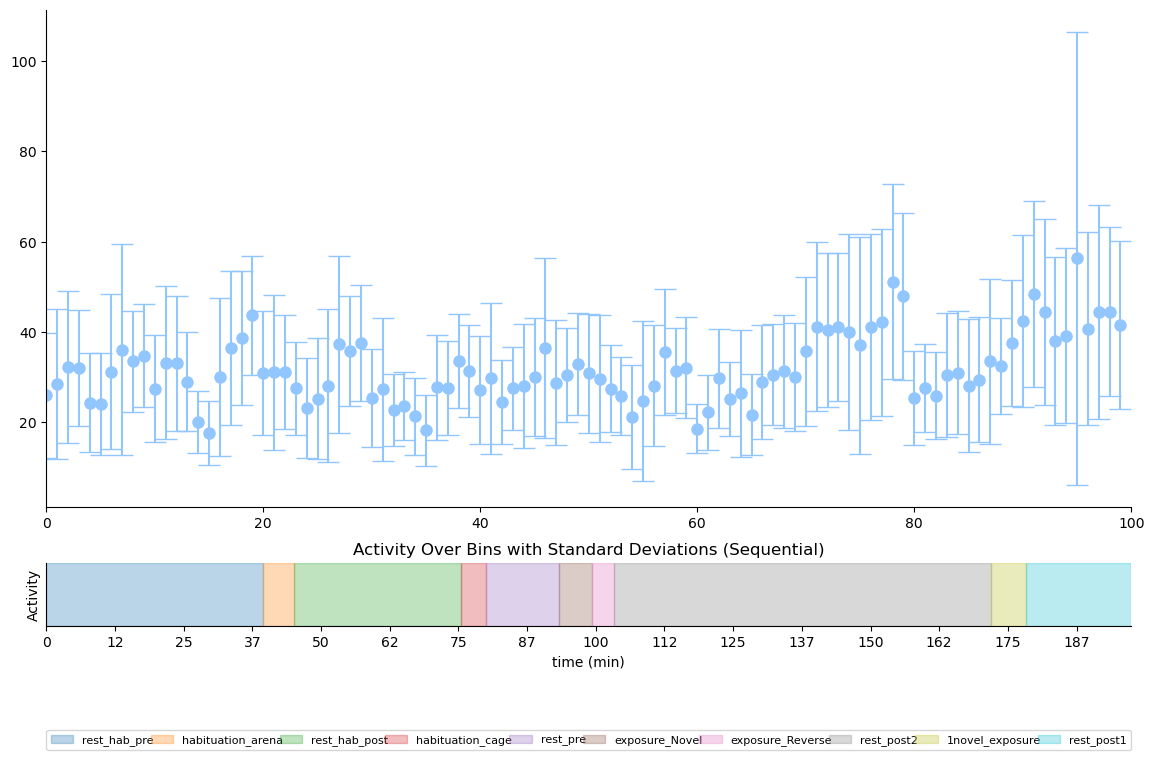

In [238]:
# Plotting
fig = plt.figure(figsize=(14, 8))
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
axs = []
intervals = []
start = 0
for length in epoch_lengths:
    end = start + length
    intervals.append((start, end))
    start = end
gs = gridspec.GridSpec(2, 1, height_ratios=[8, 1])
axs.append(fig.add_subplot(gs[0]))
axs.append(fig.add_subplot(gs[1]))

# Plotting the data with error bars
axs[0].errorbar(x =x_range, y=all_means_nonSocial, yerr=all_stds_nonSocial, fmt='o', markersize=8, capsize=8)
axs[0].set_xlim(0,len(all_means_Social))

behavior = ['rest_hab_pre','habituation_arena','rest_hab_post','habituation_cage','rest_pre',
                'exposure_Novel','exposure_Reverse','rest_post2','1novel_exposure','rest_post1']
colors = list(mcolors.TABLEAU_COLORS.values())
b = 0.025 
for i, (start, end) in enumerate(intervals):
    axs[1].axvspan(start, end, alpha=0.3, color=colors[i % len(colors)], label=list(assembly_activities.keys())[i])
    axs[1].yaxis.set_major_locator(ticker.NullLocator())
    axs[1].set_xlim(0,intervals[i][1])
    plt.xticks(np.arange(0, intervals[i][1], step=30000), labels=[str(int(i*b//60)) for i in np.arange(0, intervals[i][1], step=30000)])
    axs[1].legend(labels=behavior, loc="lower right", bbox_to_anchor=(0, -2, 1, 0.1), ncols=len(behavior), mode="expand", borderaxespad=0, fontsize=8)
    axs[1].set_xlabel('time (min)')

#plt.xticks(ticks=np.arange(0, len(all_means_nonSocial), num_bins), labels=binned_means.keys())

#plt.xlabel('Conditions')
plt.ylabel('Activity')
plt.title('Activity Over Bins with Standard Deviations (Sequential)')
plt.show()